Grid dimensions (rows, cols): (3, 3)

Grid representation of warehouse:
 F0_0  F0_1  F0_2 
 S1_0  A1_1  S1_2 
 B2_0  B2_1  B2_2 

Warehouse nodes DataFrame:
      id  aisle  slot   type    x    y  is_io
0     F1      1     0  front  0.0  0.0   True
1  A1_01      1     1   slot  0.0  1.0  False
2     B1      1     2   back  0.0  1.0  False

Adjacency matrix:
       F1  A1_01  B1
F1      0      1   0
A1_01   1      0   1
B1      0      1   0

Adjacency dictionary:
{'A1_01': ['F1', 'B1'], 'B1': ['A1_01'], 'F1': ['A1_01']}

Generated orders:
[Order(order_id='O1', items=[Item(sku='S1_1', slot='A1_01')], size=1),
 Order(order_id='O2', items=[Item(sku='S2_1', slot='A1_01')], size=3),
 Order(order_id='O3', items=[Item(sku='S3_1', slot='A1_01')], size=2),
 Order(order_id='O4', items=[Item(sku='S4_1', slot='A1_01')], size=1),
 Order(order_id='O5', items=[Item(sku='S5_1', slot='A1_01')], size=4)]

Required slots for all orders: ['A1_01']

Graph representation of warehouse:
       F1*        
    

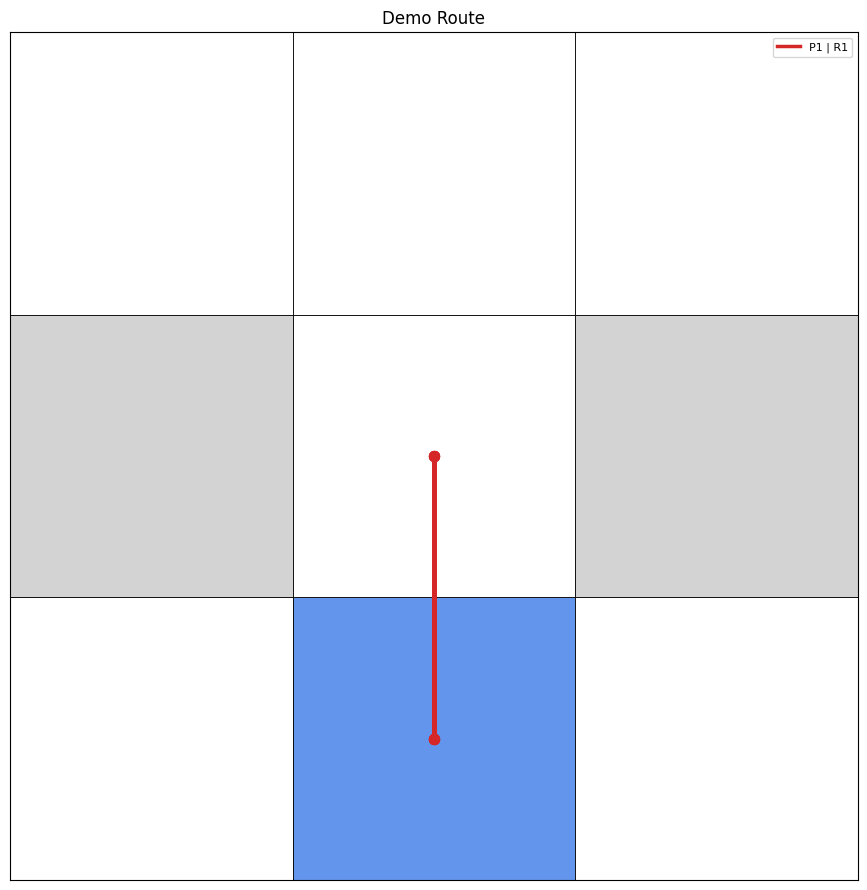

In [1]:
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional, Iterable
import pandas as pd
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.axes
import itertools
import numpy as np
from pprint import pprint


COLORS = {
    "back": "white",
    "front": "white",
    "aisle": "white",
    "io": "cornflowerblue",
    "slot": "lightgray",
}


@dataclass
class NodeGrid:
    """Grid representation of a node in the warehouse."""

    row: int
    col: int
    node_type: str  # 'front', 'back', 'aisle', 'slot', 'io'
    is_io: bool = False

    def __post_init__(self) -> None:
        """Initialize the color based on the node type."""
        if self.node_type in COLORS:
            self.color = COLORS["io"] if self.is_io else COLORS[self.node_type]
        else:
            self.color = "white"

        self.id = f"{self.node_type[0].upper()}{self.row}_{self.col}"

    def __str__(self) -> str:
        """String representation of the node."""
        return self.id


@dataclass
class Node:
    """Represents a location node in the warehouse."""

    aisle: int
    slot: int
    node_type: str  # 'front', 'back', or 'slot'
    x_coord: float
    y_coord: float
    grid_coord: Tuple[int, int] = field(default_factory=tuple)
    is_io: bool = False

    @property
    def id(self) -> str:
        """Generate a unique identifier for the node."""
        if self.node_type == "front":
            return f"F{self.aisle}"
        elif self.node_type == "back":
            return f"B{self.aisle}"
        elif self.node_type == "slot":
            return f"A{self.aisle}_{self.slot:02d}"
        raise ValueError(f"Unknown node type: {self.node_type}")


@dataclass
class Item:
    """Represents an item in an order."""

    sku: str
    slot: str


@dataclass
class Order:
    """Represents a customer order."""

    order_id: str
    items: List[Item]
    size: int  # number of items


@dataclass
class Route:
    """Represents a picking route for a single picker."""

    route_id: str
    picker_id: str
    orders: List[str]
    path: List[str]


@dataclass
class Solution:
    """Container for a complete routing solution."""

    routes: List[Route]


@dataclass
class Warehouse:
    """
    Warehouse configuration and operations.

    Parameters
    ----------
    num_aisles : int
        Number of parallel aisles in the warehouse.
    slots_per_side : int
        Number of storage locations per side of each aisle.
    aisle_length_m : float
        Length of each aisle in meters.
    aisle_spacing_m : float
        Spacing between aisles in meters.
    slot_pitch_m : float
        Pitch between slots in meters.
    io_node : str
        Identifier of the input/output node.

    Attributes
    ----------
    nodes : List[Node]
        All nodes in the warehouse.
    slot_nodes : List[Node]
        Slot nodes.
    front_nodes : List[Node]
        Front cross-aisle nodes.
    back_nodes : List[Node]
        Back cross-aisle nodes.
    adjacency_dict : Dict[str, List[str]]
        Adjacency dictionary for the graph.
    adjacency_matrix : pd.DataFrame
        Adjacency matrix for the graph.
    slot_dict : Dict[str, Node]
        Dictionary of slot nodes by ID.
    node_df : pd.DataFrame
        DataFrame of all nodes.
    grid : List[List[NodeGrid]]
        Grid representation of the warehouse.
    """

    num_aisles: int
    slots_per_side: int
    aisle_length_m: float
    aisle_spacing_m: float
    slot_pitch_m: float
    io_node: str

    nodes: List[Node] = field(default_factory=list, init=False, repr=False)
    slot_nodes: List[Node] = field(default_factory=list, init=False, repr=False)
    front_nodes: List[Node] = field(default_factory=list, init=False, repr=False)
    back_nodes: List[Node] = field(default_factory=list, init=False, repr=False)

    def __post_init__(self) -> None:
        """Initialize the warehouse nodes and related structures."""
        self.generate_nodes()
        self.adjacency_dict = self._create_adjacency_dict()
        self.adjacency_matrix = self._create_adjacency_matrix()
        self.slot_dict = {node.id: node for node in self.slot_nodes}
        self.node_df = self._create_node_dataframe()
        self.grid = self._create_node_grid()
        self.grid_repr = self._create_grid_repr()

    def generate_nodes(self) -> None:
        """Generate all warehouse nodes (slots, front, and back cross-aisles)."""
        # Create slot nodes
        self.slot_nodes = [
            Node(
                aisle=aisle,
                slot=slot_num,
                node_type="slot",
                x_coord=(aisle - 1) * self.aisle_spacing_m,
                y_coord=slot_num * self.slot_pitch_m,
                grid_coord=(aisle * 3 - 2, slot_num),
            )
            for aisle in range(1, self.num_aisles + 1)
            for slot_num in range(1, self.slots_per_side + 1)
        ]

        # Create front cross-aisle nodes
        self.front_nodes = [
            Node(
                aisle=aisle,
                slot=0,
                node_type="front",
                y_coord=0.0,
                x_coord=(aisle - 1) * self.aisle_spacing_m,
                is_io=(f"F{aisle}" == self.io_node),
                grid_coord=(aisle * 3 - 2, 0),
            )
            for aisle in range(1, self.num_aisles + 1)
        ]

        # Create back cross-aisle nodes
        self.back_nodes = [
            Node(
                aisle=aisle,
                slot=self.slots_per_side + 1,
                node_type="back",
                x_coord=(aisle - 1) * self.aisle_spacing_m,
                y_coord=self.aisle_length_m,
                is_io=(f"B{aisle}" == self.io_node),
                grid_coord=(aisle * 3 - 2, self.slots_per_side + 1),
            )
            for aisle in range(1, self.num_aisles + 1)
        ]

        # Combine all nodes
        self.nodes = self.front_nodes + self.slot_nodes + self.back_nodes

        # Node dict for quick lookup
        self.node_dict: Dict[str, Node] = {node.id: node for node in self.nodes}

    @property
    def grid_height(self) -> int:
        """Calculate the height of the warehouse grid."""
        return self.slots_per_side + 2

    @property
    def grid_width(self) -> int:
        """Calculate the total width of the warehouse in grid units."""
        return self.num_aisles * 3

    @property
    def grid_dimensions(self) -> Tuple[int, int]:
        """Return the dimensions of the warehouse grid (rows, columns)."""
        return self.grid_height, self.grid_width

    @property
    def grid_coord_io(self) -> Tuple[int, int]:
        """Get the grid coordinates of the I/O node."""
        depot_col = int(self.io_node[1:]) * 3 - 2
        depot_row = 0 if self.io_node.startswith("F") else self.grid_height - 1
        return depot_row, depot_col

    def generate_layout_text(self, spacing: int = 5) -> str:
        """
        Generate a textual representation of the warehouse layout with node IDs.

        Parameters
        ----------
        spacing : int, optional
            Spacing for centering node IDs (default is 5).

        Returns
        -------
        str
            Textual representation of the warehouse layout.
        """
        grid = [[" " for _ in range(self.grid_width)] for _ in range(self.grid_height)]

        # Populate front cross aisle
        for front_node in self.front_nodes:
            col = (front_node.aisle - 1) * 3 + 1  # Middle column
            grid[0][col] = f"{front_node.id}{'*' if front_node.is_io else ''}"

        # Populate back cross aisle
        for back_node in self.back_nodes:
            col = (back_node.aisle - 1) * 3 + 1  # Middle column
            grid[-1][col] = f"{back_node.id}{'*' if back_node.is_io else ''}"

        # Populate aisle slots
        for slot_node in self.slot_nodes:
            col = (slot_node.aisle - 1) * 3 + 1  # Middle column
            row = slot_node.slot
            grid[row][col] = slot_node.id

        return "\n".join("".join(f"{cell}".center(spacing) for cell in row) for row in grid)

    def _create_node_grid(self) -> List[List[NodeGrid]]:
        """
        Generate a grid of NodeGrid objects representing the warehouse layout.

        Returns
        -------
        List[List[NodeGrid]]
            Grid of warehouse nodes.
        """
        num_rows = self.grid_height
        num_cols = self.grid_width

        # Initialize grid
        grid = [[" " for _ in range(num_cols)] for _ in range(num_rows)]

        for row_idx in range(num_rows):
            for col_idx in range(num_cols):
                is_cross_aisle = row_idx == 0 or row_idx == num_rows - 1
                is_shelf_column = col_idx % 3 != 1

                if not is_cross_aisle and is_shelf_column:
                    grid[row_idx][col_idx] = NodeGrid(row_idx, col_idx, "slot")
                elif is_cross_aisle and row_idx == num_rows - 1:
                    grid[row_idx][col_idx] = NodeGrid(row_idx, col_idx, "back")
                elif is_cross_aisle and row_idx == 0:
                    grid[row_idx][col_idx] = NodeGrid(row_idx, col_idx, "front")
                else:
                    grid[row_idx][col_idx] = NodeGrid(row_idx, col_idx, "aisle")

        depot_row, depot_col = self.grid_coord_io
        grid[depot_row][depot_col] = NodeGrid(depot_row, depot_col, "front", is_io=True)

        return grid

    def _create_grid_repr(self, show_coords: bool = False, spacing: int = 6) -> str:
        """
        Generate a character-based grid representation of the warehouse layout.

        Parameters
        ----------
        show_coords : bool, optional
            Whether to show coordinates (default is False).
        spacing : int, optional
            Spacing for centering cells (default is 3).

        Returns
        -------
        str
            Textual grid representation.
        """
        num_rows, num_cols = self.grid_dimensions
        grid = [[" " for _ in range(num_cols)] for _ in range(num_rows)]
        
        for row_idx in range(num_rows):
            for col_idx in range(num_cols):
                grid[row_idx][col_idx] = str(self.grid[row_idx][col_idx])

        if show_coords:
            # Add row labels
            for row_idx in range(num_rows):
                grid[row_idx].insert(0, f"{row_idx}".center(spacing))

            # Add column header row
            col_header = [f"{col_idx}".center(spacing) for col_idx in range(num_cols)]
            col_header.insert(0, "".center(spacing))
            grid.insert(0, col_header)

        return "\n".join("".join(f"{cell}".center(spacing) for cell in row) for row in grid)

    def _create_node_dataframe(self) -> pd.DataFrame:
        """
        Generate a DataFrame representation of the warehouse nodes.

        Returns
        -------
        pd.DataFrame
            DataFrame containing node information.
        """
        return pd.DataFrame(
            [
                {
                    "id": node.id,
                    "aisle": node.aisle,
                    "slot": node.slot,
                    "type": node.node_type,
                    "x": node.x_coord,
                    "y": node.y_coord,
                    "is_io": node.is_io,
                }
                for node in self.nodes
            ]
        )

    def is_front_node(self, node_id: str) -> bool:
        """Check if a node is a front cross-aisle node."""
        return node_id.startswith("F")

    def is_back_node(self, node_id: str) -> bool:
        """Check if a node is a back cross-aisle node."""
        return node_id.startswith("B")

    def is_slot_node(self, node_id: str) -> bool:
        """Check if a node is a slot node."""
        return node_id.startswith("A")

    def parse_cross_node(self, node_id: str) -> Tuple[str, int]:
        """
        Parse a cross-aisle node identifier (e.g., 'F1' -> ('F', 1)).

        Parameters
        ----------
        node_id : str
            Node identifier.

        Returns
        -------
        Tuple[str, int]
            Type and aisle number.
        """
        return node_id[0], int(node_id[1:])

    def parse_slot_node(self, node_id: str) -> Tuple[str, int, int]:
        """
        Parse a slot node identifier (e.g., 'A12_34' -> ('A', 12, 34)).

        Parameters
        ----------
        node_id : str
            Node identifier.

        Returns
        -------
        Tuple[str, int, int]
            Type, aisle, slot.
        """
        side = node_id[0]
        aisle_str, slot_str = node_id[1:].split("_")
        return side, int(aisle_str), int(slot_str)

    def are_adjacent(self, node_u: str, node_v: str) -> bool:
        """
        Determine if two nodes are adjacent in the warehouse graph.

        Parameters
        ----------
        node_u : str
            First node ID.
        node_v : str
            Second node ID.

        Returns
        -------
        bool
            True if adjacent, False otherwise.
        """
        # Cross-aisle to cross-aisle (same type)
        if (self.is_front_node(node_u) and self.is_front_node(node_v)) or (
            self.is_back_node(node_u) and self.is_back_node(node_v)
        ):
            _, aisle_i = self.parse_cross_node(node_u)
            _, aisle_j = self.parse_cross_node(node_v)
            return abs(aisle_i - aisle_j) == 1

        # Front to slot
        if self.is_front_node(node_u) and self.is_slot_node(node_v):
            _, aisle, slot_num = self.parse_slot_node(node_v)
            return self.parse_cross_node(node_u)[1] == aisle and slot_num == 1

        # Back to slot
        if self.is_back_node(node_u) and self.is_slot_node(node_v):
            _, aisle, slot_num = self.parse_slot_node(node_v)
            return self.parse_cross_node(node_u)[1] == aisle and slot_num == self.slots_per_side

        # Slot to cross-aisle (symmetric check)
        if self.is_slot_node(node_u) and (self.is_front_node(node_v) or self.is_back_node(node_v)):
            return self.are_adjacent(node_v, node_u)

        # Slot to slot (same aisle, consecutive slots)
        if self.is_slot_node(node_u) and self.is_slot_node(node_v):
            _, aisle_u, slot_u = self.parse_slot_node(node_u)
            _, aisle_v, slot_v = self.parse_slot_node(node_v)
            return aisle_u == aisle_v and abs(slot_u - slot_v) == 1

        return False

    def _create_adjacency_dict(self) -> Dict[str, List[str]]:
        """
        Create an adjacency dictionary for the warehouse graph.

        Returns
        -------
        Dict[str, List[str]]
            Adjacency dictionary.
        """
        adj_dict = {}
        node_ids = [node.id for node in self.nodes]

        for node_u in node_ids:
            adj_dict[node_u] = [
                node_v for node_v in node_ids if node_u != node_v and self.are_adjacent(node_u, node_v)
            ]

        return adj_dict

    def _create_adjacency_matrix(self) -> pd.DataFrame:
        """
        Create an adjacency matrix for the warehouse graph.

        Returns
        -------
        pd.DataFrame
            Adjacency matrix.
        """
        node_ids = [node.id for node in self.nodes]
        adj_matrix = pd.DataFrame(0, index=node_ids, columns=node_ids)

        for i, node_u in enumerate(node_ids):
            for j, node_v in enumerate(node_ids):
                if i != j and self.are_adjacent(node_u, node_v):
                    adj_matrix.at[node_u, node_v] = 1

        return adj_matrix

    def calculate_step_cost(self, node_u: str, node_v: str) -> float:
        """
        Calculate the cost of moving between two adjacent nodes.

        Parameters
        ----------
        node_u : str
            Starting node ID.
        node_v : str
            Ending node ID.

        Returns
        -------
        float
            Step cost in meters.

        Raises
        ------
        ValueError
            If nodes are not adjacent.
        """
        if not self.are_adjacent(node_u, node_v):
            raise ValueError(f"Nodes are not adjacent: {node_u} -> {node_v}")

        # Cross-aisle to cross-aisle
        if (self.is_front_node(node_u) and self.is_front_node(node_v)) or (
            self.is_back_node(node_u) and self.is_back_node(node_v)
        ):
            return self.aisle_spacing_m

        # Front to slot or slot to front
        if (self.is_front_node(node_u) and self.is_slot_node(node_v)) or (
            self.is_slot_node(node_u) and self.is_front_node(node_v)
        ):
            slot_num = (
                self.parse_slot_node(node_v)[2]
                if self.is_slot_node(node_v)
                else self.parse_slot_node(node_u)[2]
            )
            return slot_num * self.slot_pitch_m

        # Back to slot or slot to back
        if (self.is_back_node(node_u) and self.is_slot_node(node_v)) or (
            self.is_slot_node(node_u) and self.is_back_node(node_v)
        ):
            slot_num = (
                self.parse_slot_node(node_v)[2]
                if self.is_slot_node(node_v)
                else self.parse_slot_node(node_u)[2]
            )
            return abs(self.aisle_length_m - slot_num * self.slot_pitch_m)

        # Slot to slot (same aisle)
        return self.slot_pitch_m

    def get_node_coordinates(self, node_id: str) -> Tuple[float, float]:
        """
        Calculate the coordinates of a node in the warehouse.

        Parameters
        ----------
        node_id : str
            Node identifier.

        Returns
        -------
        Tuple[float, float]
            (x, y) coordinates.
        """
        if self.is_front_node(node_id) or self.is_back_node(node_id):
            front_back, aisle = self.parse_cross_node(node_id)
            y_coord = 0.0 if front_back == "F" else self.aisle_length_m
            return (aisle - 1) * self.aisle_spacing_m, y_coord

        _, aisle, slot_num = self.parse_slot_node(node_id)
        return (aisle - 1) * self.aisle_spacing_m, slot_num * self.slot_pitch_m

    def calculate_path_distance(self, path: List[str]) -> float:
        """
        Calculate the total distance of a given path.

        Parameters
        ----------
        path : List[str]
            List of node IDs in the path.

        Returns
        -------
        float
            Total distance in meters.
        """
        return sum(self.calculate_step_cost(u, v) for u, v in zip(path, path[1:]))

    def validate_path(self, path: List[str], required_slots: Iterable[str]) -> Tuple[bool, str]:
        """
        Validate a picking path.

        Parameters
        ----------
        path : List[str]
            List of node IDs in the path.
        required_slots : Iterable[str]
            Required slot nodes to visit.

        Returns
        -------
        Tuple[bool, str]
            (Valid, Message).
        """
        if not path:
            return False, "Empty path"

        # Check start and end at I/O
        if path[0] != self.io_node or path[-1] != self.io_node:
            return False, "Path must start and end at I/O"

        # Check adjacency
        for u, v in zip(path, path[1:]):
            if not self.are_adjacent(u, v):
                return False, f"Non-adjacent step {u} -> {v}"

        # Check required slots visited
        needed_slots = set(required_slots)
        visited_slots = set(node_id for node_id in path if self.is_slot_node(node_id))

        if not needed_slots.issubset(visited_slots):
            return False, f"Missing slots: {sorted(needed_slots - visited_slots)}"

        return True, "OK"

    def validate_solution(self, solution: Solution, orders: List[Order]) -> Tuple[bool, str]:
        """
        Validate a complete solution.

        Parameters
        ----------
        solution : Solution
            The solution to validate.
        orders : List[Order]
            List of orders.

        Returns
        -------
        Tuple[bool, str]
            (Valid, Message).
        """
        orders_by_id = {order.order_id: order for order in orders}
        assigned_orders = {order_id: False for order_id in orders_by_id}

        for route in solution.routes:
            required_slots = get_required_slots_for_orders(route.orders, orders)
            is_valid, message = self.validate_path(route.path, required_slots)
            if not is_valid:
                return False, f"Route {route.route_id}: {message}"

            for order_id in route.orders:
                if assigned_orders[order_id]:
                    return False, f"Order {order_id} appears in multiple routes"
                assigned_orders[order_id] = True

        unassigned_orders = [order_id for order_id, assigned in assigned_orders.items() if not assigned]
        if unassigned_orders:
            return False, f"Unassigned orders: {unassigned_orders}"

        return True, "OK"

    def calculate_solution_distance(self, solution: Solution) -> float:
        """
        Calculate total distance for all routes in solution.

        Parameters
        ----------
        solution : Solution
            The solution.

        Returns
        -------
        float
            Total distance in meters.
        """
        return sum(self.calculate_path_distance(route.path) for route in solution.routes)

    def calculate_solution_travel_time(self, solution: Solution, speed_mps: float = 1.2) -> float:
        """
        Calculate total travel time for all routes in solution.

        Parameters
        ----------
        solution : Solution
            The solution.
        speed_mps : float, optional
            Walking speed in meters per second (default is 1.2).

        Returns
        -------
        float
            Total travel time in seconds.
        """
        total_distance = self.calculate_solution_distance(solution)
        return total_distance / speed_mps if speed_mps > 0 else 0.0

    def calculate_route_time_seconds(
        self,
        route: Route,
        orders: List[Order],
        speed_mps: float = 1.2,
        pick_time_sec: float = 3.0,
    ) -> float:
        """
        Calculate travel time + pick handling time for a route.

        Parameters
        ----------
        route : Route
            The route.
        orders : List[Order]
            List of all orders.
        speed_mps : float, optional
            Walking speed in m/s (default is 1.2).
        pick_time_sec : float, optional
            Time to pick one item in seconds (default is 3.0).

        Returns
        -------
        float
            Total time in seconds.
        """
        distance = self.calculate_path_distance(route.path)
        item_count = get_item_count_for_orders(route.orders, orders)
        travel_time = distance / max(speed_mps, 1e-6)
        handling_time = item_count * pick_time_sec
        return travel_time + handling_time

    def calculate_picker_finish_times(
        self,
        solution: Solution,
        orders: List[Order],
        speed_mps: float = 1.2,
        pick_time_sec: float = 3.0,
    ) -> Dict[str, float]:
        """
        Calculate finish time (seconds) per picker.

        Parameters
        ----------
        solution : Solution
            The solution.
        orders : List[Order]
            List of orders.
        speed_mps : float, optional
            Walking speed in m/s (default is 1.2).
        pick_time_sec : float, optional
            Pick time per item in seconds (default is 3.0).

        Returns
        -------
        Dict[str, float]
            Finish times per picker ID.
        """
        routes_per_picker = defaultdict(list)
        for route in solution.routes:
            routes_per_picker[route.picker_id].append(route)

        finish_times = {}
        for picker_id, routes in routes_per_picker.items():
            total_time = sum(
                self.calculate_route_time_seconds(route, orders, speed_mps, pick_time_sec)
                for route in routes
            )
            finish_times[picker_id] = total_time

        return finish_times

    def calculate_solution_makespan(
        self,
        solution: Solution,
        orders: List[Order],
        speed_mps: float = 1.2,
        pick_time_sec: float = 3.0,
    ) -> float:
        """
        Calculate the maximum completion time among all pickers.

        Parameters
        ----------
        solution : Solution
            The solution.
        orders : List[Order]
            List of orders.
        speed_mps : float, optional
            Walking speed in m/s (default is 1.2).
        pick_time_sec : float, optional
            Pick time per item in seconds (default is 3.0).

        Returns
        -------
        float
            Makespan in seconds.
        """
        finish_times = self.calculate_picker_finish_times(solution, orders, speed_mps, pick_time_sec)
        return max(finish_times.values()) if finish_times else 0.0

    def get_all_slots(self) -> List[str]:
        """Get list of all slot node IDs."""
        return [node.id for node in self.slot_nodes]

    def generate_orders(
        self, num_orders: int,  max_items_per_order: int = 6, seed: Optional[int] = 42
    ) -> List[Order]:
        """
        Generate random orders for testing.

        Parameters
        ----------
        num_orders : int
            Number of orders to generate.
        max_items_per_order : int, optional
            Maximum items per order (default is 6).
        seed : int, optional
            Random seed for reproducibility (default is 42).

        Returns
        -------
        List[Order]
            Generated orders.

        Examples
        --------
        >>> wh = Warehouse(...)
        >>> orders = wh.generate_orders(5)
        """

        rnd = random.Random(seed)

        all_slots = self.get_all_slots()
        orders = []

        for order_num in range(1, num_orders + 1):
            item_count = rnd.randint(1, max_items_per_order)

            # Randomly sample unique slots for the order
            chosen_slots = rnd.sample(
                all_slots,
                # Ensure we don't sample more slots than available
                min(item_count, len(all_slots))
            )
            
            items = []
            for item_idx, slot_id in enumerate(chosen_slots):
                sku_id = f"S{order_num}_{item_idx+1}"
                item = Item(sku=sku_id, slot=slot_id)
                items.append(item)

            order = Order(
                order_id=f"O{order_num}",
                items=items,
                size=item_count,
            )

            orders.append(order)

        return orders

    def generate_solution(self, orders: List[Order], policy: callable, bin_size: int) -> Solution:
        """
        Generate a solution using a specified routing policy.

        Parameters
        ----------
        orders : List[Order]
            List of orders.
        policy : callable
            Policy method that takes orders, warehouse, and bin_size.
        bin_size : int
            Maximum number of items.

        Returns
        -------
        Solution
            Generated solution.
        """
        return policy(orders, self, bin_size)


    

    def _node_to_grid_coords(self, node_id: str) -> Tuple[int, int]:
        """
        Convert a node ID to its corresponding grid coordinates in the warehouse.

        Parameters
        ----------
        node_id : str
            The identifier of the node (e.g., 'F1', 'B2', 'A1_03').

        Returns
        -------
        Tuple[int, int]
            The grid coordinates (row, column) of the node.

        Notes
        -----
        - Front nodes are located in the first row (row 0).
        - Back nodes are located in the last row.
        - Slot nodes are located in rows corresponding to their slot number.
        - Columns are determined based on the aisle and node type.
        """

        def _get_aisle_columns(aisle: int) -> Tuple[int, int, int]:
            """
            Calculate the column indices for a given aisle.

            Parameters
            ----------
            aisle : int
                The aisle number.

            Returns
            -------
            Tuple[int, int, int]
                The left, middle, and right column indices for the aisle.
            """
            base_col = (aisle - 1) * 3
            return base_col, base_col + 1, base_col + 2

        # Get the total number of rows in the warehouse grid
        num_rows, _ = self.grid_dimensions

        # Handle front cross-aisle nodes
        if self.is_front_node(node_id):
            aisle = int(node_id[1:])  # Extract aisle number from node ID
            _, mid_col, _ = _get_aisle_columns(aisle)
            return 0, mid_col  # Front nodes are in row 0

        # Handle back cross-aisle nodes
        if self.is_back_node(node_id):
            aisle = int(node_id[1:])  # Extract aisle number from node ID
            _, mid_col, _ = _get_aisle_columns(aisle)
            return num_rows - 1, mid_col  # Back nodes are in the last row

        # Handle slot nodes
        _, aisle, slot_num = self.parse_slot_node(node_id)  # Parse slot node ID
        _, mid_col, _ = _get_aisle_columns(aisle)
        return slot_num, mid_col  # Slot nodes are in rows corresponding to their slot number
    
    
    def _plot_single_route(
        self, ax: matplotlib.axes.Axes, color: str, route: Route
    ) -> None:
        """
        Plots a single route on the warehouse grid.

        Parameters
        ----------
        self : Warehouse
            The warehouse.
        ax : matplotlib.axes.Axes
            The axis.
        color : str
            Color for the route.
        route : Route
            The route.
        """
        # Convert route nodes to grid points
        grid_points = [self._node_to_grid_coords(node_id) for node_id in route.path]

        # Center points
        centered_points = [(col + 0.5, row + 0.5) for row, col in grid_points]
        xs, ys = zip(*centered_points) if centered_points else ([], [])

        # Label the route
        label = f"{route.picker_id} | {route.route_id}"

        # Plot the route as a line
        ax.plot(xs, ys, linewidth=2.5, color=color, label=label)

        ax.scatter(xs, ys, s=50, color=color)

    def _draw_warehouse_grid(self, ax: matplotlib.axes.Axes,) -> None:
        """
        Draws a grid representation of a warehouse layout on the given matplotlib axis.

        Parameters
        ----------
        self : Warehouse
            The warehouse.
        ax : matplotlib.axes.Axes
            The axis to draw on.
        
        """
        grid = self.grid
        num_rows, num_cols = self.grid_dimensions

        for row_idx in range(num_rows):
            for col_idx in range(num_cols):
                color = grid[row_idx][col_idx].color
                rect = plt.Rectangle(
                    (col_idx, row_idx), 1, 1, fc=color, ec="black", lw=0.6
                )
                ax.add_patch(rect)


    def plot_warehouse_routes(
        self, solution: Solution, title: str = "Warehouse routes"
    ) -> None:
        """
        Visualize warehouse routes for order picking.

        Parameters
        ----------
        self : Warehouse
            The warehouse.
        solution : Solution
            The solution object containing the routes.
        title : str, optional
            Plot title (default is "Warehouse routes").
        """
        num_rows, num_cols = self.grid_dimensions

        fig, ax = plt.subplots(figsize=(10, 9))

        self._draw_warehouse_grid(ax)

        color_cycle = itertools.cycle(["tab:red", "tab:green", "tab:blue", "tab:orange", "tab:purple"])
        for route in solution.routes:
            self._plot_single_route(ax, next(color_cycle), route)

        ax.set_xlim(0, num_cols)
        ax.set_ylim(0, num_rows)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        ax.set_title(title)
        ax.legend(loc="upper right", fontsize=8)
        plt.tight_layout()
        plt.show()



def get_required_slots_for_orders(order_ids: List[str], all_orders: List[Order]) -> List[str]:
    """
    Extract unique slot locations required for given orders.

    Parameters
    ----------
    order_ids : List[str]
        List of order IDs.
    all_orders : List[Order]
        List of all orders.

    Returns
    -------
    List[str]
        Sorted list of required slot IDs.
    """
    return sorted(
        {
            item.slot
            for order in all_orders
            if order.order_id in order_ids
            for item in order.items
        }
    )


def get_item_count_for_orders(order_ids: List[str], all_orders: List[Order]) -> int:
    """
    Count total items across given orders.

    Parameters
    ----------
    order_ids : List[str]
        List of order IDs.
    all_orders : List[Order]
        List of all orders.

    Returns
    -------
    int
        Total item count.
    """
    order_id_set = set(order_ids)
    return sum(order.size for order in all_orders if order.order_id in order_id_set)



def policy_pick_and_return(orders: List[Order], warehouse: Warehouse, bin_size: int) -> Solution:
    """
    Simple policy: pick all items one by one and return to I/O each time.

    Parameters
    ----------
    orders : List[Order]
        List of orders.
    warehouse : Warehouse
        The warehouse.
    bin_size : int
        Maximum number of items (not used in this policy).

    Returns
    -------
    Solution
        Generated solution.
    """
    all_items = [item for order in orders for item in order.items]
    path = []

    io_node = warehouse.node_dict[warehouse.io_node]

    for item in all_items:
        aisle = warehouse.node_dict[item.slot].aisle
        slot_num = warehouse.node_dict[item.slot].slot

        # Path from I/O to front of aisle
        path_from_io_to_front = []
        target_front = warehouse.node_dict[f"F{aisle}"]

        if io_node.aisle > target_front.aisle:
            for k in range(io_node.aisle, target_front.aisle - 1, -1):
                path_from_io_to_front.append(warehouse.node_dict[f"F{k}"])
        elif io_node.aisle < target_front.aisle:
            for k in range(io_node.aisle, target_front.aisle + 1):
                path_from_io_to_front.append(warehouse.node_dict[f"F{k}"])
        else:
            path_from_io_to_front.append(io_node)

        # Path from front to slot
        path_from_front_to_slot = []
        for t in range(1, slot_num + 1):
            path_from_front_to_slot.append(warehouse.node_dict[f"A{aisle}_{t:02d}"])

        # Reverse path to return to front
        path_from_slot_to_front = list(reversed(path_from_front_to_slot[:-1]))  # Exclude slot

        # Reverse path to return to I/O
        path_from_front_to_io = list(reversed(path_from_io_to_front))

        # Combine segments
        path.extend(
            path_from_io_to_front
            + path_from_front_to_slot
            + path_from_slot_to_front
            + path_from_front_to_io[:-1]  # Exclude duplicate I/O
        )

    # Add final I/O
    path.append(io_node)

    # Convert to IDs
    path_ids = [node.id for node in path]

    return Solution(
        routes=[
            Route(
                route_id="R1",
                picker_id="P1",
                orders=[order.order_id for order in orders],
                path=path_ids,
            )
        ]
    )





def main() -> None:
    """Demonstrate warehouse functionality."""
    simple_warehouse = Warehouse(
        num_aisles=1,
        slots_per_side=1,
        aisle_length_m=1.0,
        aisle_spacing_m=3.0,
        slot_pitch_m=1.0,
        io_node="F1",
    )

    print("Grid dimensions (rows, cols):", simple_warehouse.grid_dimensions)

    print("\nGrid representation of warehouse:")
    print(simple_warehouse.grid_repr)

    print("\nWarehouse nodes DataFrame:")
    print(simple_warehouse.node_df)

    print("\nAdjacency matrix:")
    print(simple_warehouse.adjacency_matrix)

    print("\nAdjacency dictionary:")
    pprint(simple_warehouse.adjacency_dict)

    orders = simple_warehouse.generate_orders(
        num_orders=5, max_items_per_order=4
    )
    
    print("\nGenerated orders:")
    pprint(orders)

    # Demonstrate route generation
    required_slots = get_required_slots_for_orders([order.order_id for order in orders], orders)
    print("\nRequired slots for all orders:", required_slots)

    print("\nGraph representation of warehouse:")
    print(simple_warehouse.generate_layout_text(spacing=6))

    print(" \nSlot dict:")
    pprint(simple_warehouse.slot_dict)

    # Generate a demo route
    solution = simple_warehouse.generate_solution(orders, policy=policy_pick_and_return, bin_size=1)
    print("\nGenerated route path:")
    pprint(solution)

    is_valid, message = simple_warehouse.validate_solution(solution, orders)
    print("Route valid?", is_valid, "-", message)
    print("  distance (m):", simple_warehouse.calculate_solution_distance(solution))
    print(" travel time (s):", simple_warehouse.calculate_solution_travel_time(solution, speed_mps=1.0))
    print(
        "  makespan (s):",
        simple_warehouse.calculate_solution_makespan(solution, orders, speed_mps=1.0, pick_time_sec=5.0),
    )

    simple_warehouse.plot_warehouse_routes(solution, title="Demo Route")


if __name__ == "__main__":
    main()